# 1. Importing Python libraries

In [1]:
# Necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import json 
import nltk
from collections import Counter
from operator import itemgetter

# Libraries for Data preprocessing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import TweetTokenizer, RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

# Libraries for topic modeling
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

# Libraries for Data visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')

# 2. Importing Data

In [2]:
#Importing data
Project_data = "data/Nordic_Culture_Fund_Data.json"

df = pd.read_json(Project_data)
df.head()

,Year,texts
0,2005,\nLanguage research\n\nYoung people’s comprehe...
1,2016,\n\nThe Nordic Culture Fund supports an innova...
2,2006,\nNordic exhibition of the year\n\nWith the in...
3,2020,\nASSESSMENT CRITERIA &CONDITIONS 2020\nThe No...
4,2020,\nWhat is Project Funding?\nThe Nordic Culture...


# 3. Data Preprocessing

In [3]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'pilot', 'ad', 'ha', 'fee', 'apply', 'note','read',
            'previous','possibly','recurring','dkk','basis example','example','applicant wrote','wrote', 'opstart opstart',
            'doe','ass','overall','aim','was','Arne','Shed','taking','included','entire','shed light',
            'arne essay','nyheter','krone','ruth arne','ruth','torneå','karen','shed','main','year',
           'milion','receive','resulted','date','sent','paid','carried','wa','million','applied','summary', 'editor','method','arne', 'includes','wish','started',  
            'st','cap','hadza','mio','annotated','essay','bilateral','granted','criterion','needed','dagens','th','ihop','exchief','autumn','newspaper','exchief','chief','regarding']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokens = word_tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization
def lemmatize_text(text):
    tokens = casual_tokenizer(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def process_text(text):
    # Lemmatization
    text = lemmatize_text(text)
    
    # Lowercasing, removing numbers, expanding contractions, removing punctuation, and stopwords
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]

    # Replace hyphens and spaces with empty strings
    text = [re.sub(r'[-\s]', '', each) for each in text]
    
    return text

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

In [4]:
df['processed_text'] = df['texts'].apply(process_text)

# 4. Building NMF topic Model

In [5]:
texts = df['processed_text']

tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.9,
    max_features=2000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

In [6]:
nmf = NMF(
    n_components=15,
    init='nndsvd'
).fit(tfidf)

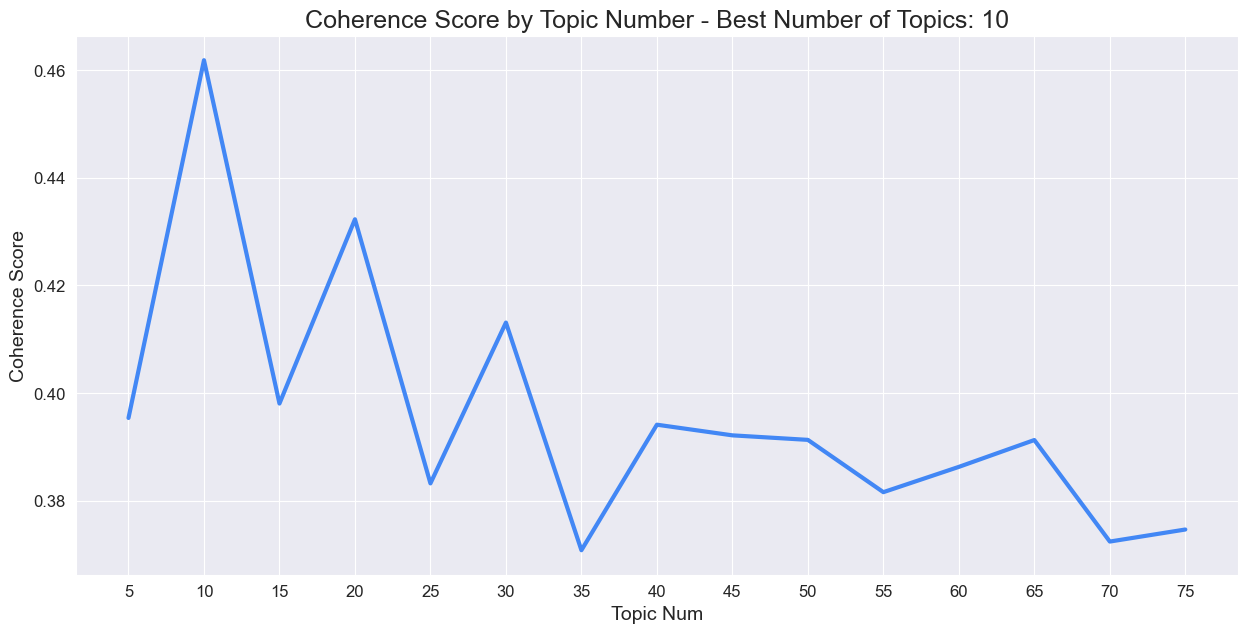

In [7]:
# Use Gensim's NMF to get the best number of topics via coherence score
texts = df['processed_text']

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Running the nmf model and calculate the coherence score
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [8]:
# Creating NMF model 
texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.9,
    max_features=2000,
    ngram_range=(1, 1),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

# Calculate Topic Weights for Each Document
doc_topic_weights = pd.DataFrame(docweights, columns=[f"Topic_{i}" for i in range(best_num_topics)])

# Aggregate Topic Weights Across the Corpus
topic_weights = doc_topic_weights.sum(axis=0)
topic_proportions = (topic_weights / topic_weights.sum()) * 100

# Display the Calculated Proportions
print(topic_proportions)

Topic_0    12.197251
Topic_1    10.032392
Topic_2    10.631913
Topic_3    12.000094
Topic_4     9.727888
Topic_5     8.225846
Topic_6    13.411390
Topic_7     6.763819
Topic_8     6.706718
Topic_9    10.302691
dtype: float64


In [9]:
# Use the top words for each cluster by tfidf weight

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 20

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) 
topic_df['topics'] = topic_df['topics'].str[0]  
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) 
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  
topic_df['topics'] = topic_df['topics'].str[0]  

topic_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,topics
0,culture,cultural,art,development,policy,support,knowledge,region,initiative,grant,...,cooperation,council,life,work,need,quality,promote,artistic,level,culture cultural art development policy suppor...
1,exhibition,museum,place,contribution,offered,extraordinary,application,twice,second,darkness,...,effort,grant,total,special,light,board,reach,taidemuseo,maximum,exhibition museum place contribution offered e...
2,support,cultural,theatre,task,medium,music,visual,cooperation,culture,transsectorial,...,islands,decisions,dance,broad,art,award,autonomous,education,literature,support cultural theatre task medium music vis...
3,funding,content,application,support,quality,projects,partner,impact,event,region,...,culture,outside,substance,selffinancing,group,country,cooperation,assessment,level,funding content application support quality pr...
4,activity,country,area,islands,cultural,involving,countries,education,denmark,cooperation,...,heritage,greenland,faroe,language,iceland,eastern,contribution,aland,new,activity country area islands cultural involvi...
5,politics,report,cultural,light,exchief,habit,partial,comprehensive,heading,islands,...,political,daily,administration,sami,model,swedish,autonomous,population,literature,politics report cultural light exchief habit p...
6,globus,global,programme,artist,new,collaboration,world,network,opstart,art,...,development,cultural,international,partnership,focus,actor,practitioner,performance,sustainable,globus global programme artist new collaborati...
7,comprehension,investigation,norwegian,young,language,people,swedish,danish,nonscandinavian,english,...,changed,youth,report,parent,languages,neighbouring,change,comparison,reveals,comprehension investigation norwegian young la...
8,museum,congo,ethnographic,stockholm,north,exhibition,object,oslo,copenhagen,november,...,exhibitions,title,came,danish,collection,colonization,bear,witness,opened,museum congo ethnographic stockholm north exhi...
9,opstart,application,idea,support,evaluates,funding,development,expense,material,region,...,phase,welcome,sufficiently,country,participating,culture,individual,engagement,start,opstart application idea support evaluates fun...


# 5. Data Visualisation

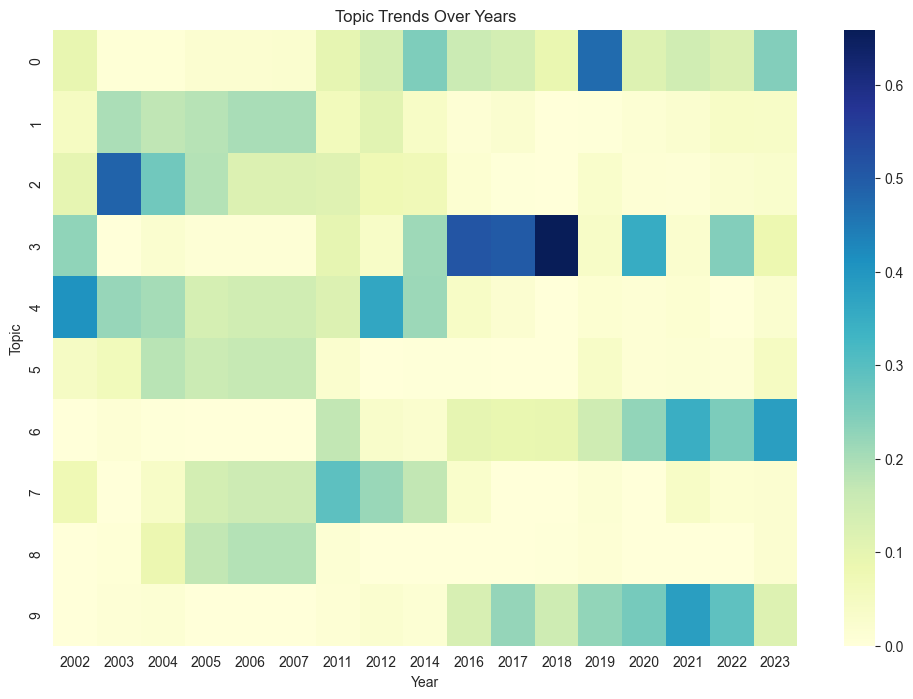

In [10]:
# Create a DataFrame from docweights
docweights_df = pd.DataFrame(docweights, index=df.index)

# Merge 'docweights_df' with 'df' based on the index
merged_df = pd.concat([df['Year'], docweights_df], axis=1)

# Aggregate topic weights by year
topic_year_agg = merged_df.groupby('Year').sum()

# Normalize the data for better visualization
topic_year_normalized = topic_year_agg.div(topic_year_agg.sum(axis=1), axis=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_year_normalized.T, cmap='YlGnBu')
plt.xlabel('Year')
plt.ylabel('Topic')
plt.title('Topic Trends Over Years')
plt.show()

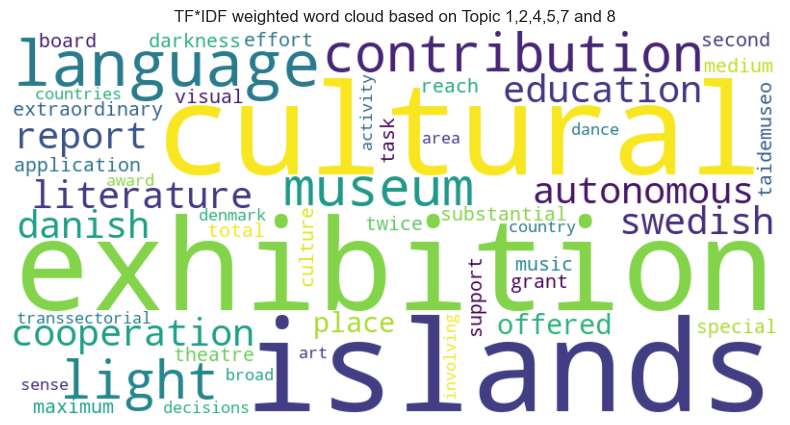

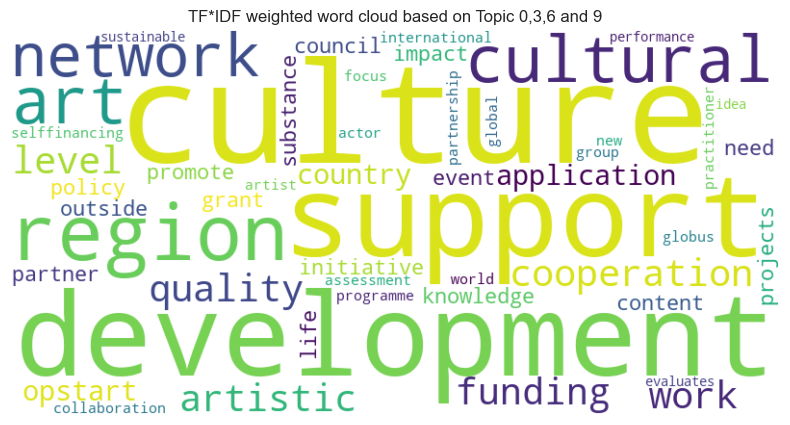

In [11]:
# Create wordcloud
def generate_word_cloud(topic_df, selected_topics, title):
    combined_words = ' '.join(topic_df.iloc[i]['topics'] for i in selected_topics)

    # Generate word cloud for the combined topics
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(combined_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Create the first wordcloud
selected_topics_2 = [1, 2, 4, 5, 7, 8]  # Adjust these indices to the topics you want
generate_word_cloud(topic_df, selected_topics_2, "TF*IDF weighted word cloud based on Topic 1,2,4,5,7 and 8")

# Create the second wordcloud
selected_topics_1 = [0, 3, 6, 9]  # Adjust these indices to the topics you want
generate_word_cloud(topic_df, selected_topics_1, "TF*IDF weighted word cloud based on Topic 0,3,6 and 9")
